# Software Defect Detection

> International Hellenic University <br />
> MSc Data Science <br />
> Machine Learning Concepts and Principles <br />
> Lazaros Panitsidis & Konstantinos Kravaritis <br />
> lpanitsidis@ihu.edu.gr & kkravaritis@ihu.edu.gr <br />
> <br />
> project in GitHub: <br />
> https://github.com/LazarosPan/Software-Defect-Detection

## Contents
1. [Python Libraries](#0)
1. [Functions](#1)
1. [Data Preprocessing](#2)
1. [ML Models](#3)
1. [Results](#4)
1. [Performance Summary of Classifiers Across Datasets](#5)

<a id='0'></a>
## Python Libraries

In [1]:
# # Install Python libraries
# %pip install -U numpy
# %pip install -U pandas
# %pip install -U seaborn
# %pip install -U matplotlib
# %pip install -U scikit-learn
# %pip install -U imbalanced-learn

In [286]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library  
import statistics as stats # https://docs.python.org/3/library/statistics.html#statistics.fmean
#import scipy.stats as spstats
import matplotlib.pyplot as plt

### Validation & Normalization methods ###
from sklearn.model_selection import cross_validate, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

### ML models ###
from sklearn.linear_model import LogisticRegression, SGDClassifier # C1 loss: log_loss => LogisticRegression with SGD
from sklearn.linear_model import Perceptron # C2
from sklearn.svm import SVC # C3
from sklearn.svm import LinearSVC # C4
from sklearn.tree import DecisionTreeClassifier # C5
from sklearn.ensemble import RandomForestClassifier # C6
from sklearn.neural_network import MLPClassifier # C7

### Metrics ###
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, make_scorer
from imblearn.metrics import geometric_mean_score # https://imbalanced-learn.org/stable/references/generated/imblearn.metrics.geometric_mean_score.html
import time
import timeit # https://stackoverflow.com/questions/17579357/time-time-vs-timeit-timeit

### Pipeline ###
from sklearn.pipeline import make_pipeline , Pipeline # https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

### Custom Modules ###
# from functions.data_types import optimize_dtypes
# from functions.dataframe_actions import df_info, df_clean
# from functions.ml_training import train_classifiers, train_classifiers_tuned

### Other configurations ###
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
# #import warnings library
# import warnings
# # ignore all warnings
# warnings.filterwarnings('ignore')

<a id='1'></a>
## Functions

#### Information about the dataframes

In [3]:
def df_info(dataframes, dataframe_names):
    """
    Finds useful information about all dataframes given in the function.

    Usage: pass a list of dataframes and their names into the function
    
    Parameters:
        dataframes = [df1, df2, ...]
        dataframe_names = ["df1", "df2", ...]

    Output: print's information about schema, missing values, duplicate values and value counts for target column.
    """

    for df, df_name in zip(dataframes, dataframe_names):
        # Check if the dataframe has at least one column
        if not df.empty:
            print("----- information for ", df_name, " -----")
            print(df_name, " : ", df.shape, "(rows, columns)")
            print(df_name, " : ", df.isna().sum().sum(), "missing values")
            print(df_name, " : ", df.duplicated().sum(), "duplicate values")

            # Identify and count values of the last column
            last_column = df.columns[-1]
            value_counts = df[last_column].value_counts()

            print(df_name, " : Value counts for ", last_column)
            print(value_counts)
        else:
            print(df_name, ': The dataframe is empty.')

#### Clean dataframe from non-numeric values

In [4]:
def df_clean(df):
  """
  Eliminate invalid data from the dataframe.

  This function replaces non-numeric values, in all the columns of the dataframe,
  with NaN and then removes rows containing these NaN values.

  Parameters:
    df: pandas DataFrame

  Returns:
    Cleaned DataFrame
  """
  df_columns = df.columns.to_list()

  # https://stackoverflow.com/questions/21771133/finding-non-numeric-rows-in-dataframe-in-pandas
    
  num_df = (
      df.drop(df_columns, axis=1)
        .join(df[df_columns].apply(pd.to_numeric, errors='coerce'))
  )

  num_df = num_df[num_df[df_columns].notnull().all(axis=1)]

  return num_df

#### Optimize data types for more efficient computation

In [5]:
def optimize_dtypes(df):
  """
  Finds the optimal data type for each variable in a DataFrame.
  
  The 'np.iinfo(), np.finfo()' functions are used to obtain the minimum and maximum values 
  for the data types accurately, ensuring better compatibility across different systems.
  If the data type of the column is non-numeric, the function ignores it and goes to the next column.

  Parameters:
    df: A pandas DataFrame.

  Returns:
    A DataFrame containing the optimal data type for each variable.
  """

  data_types_dict = {}
  for column in df.columns:
    # Get the data type of the column.
    column_type = df[column].dtype

    # Determine data types.
    if column_type in ('int8', 'int16', 'int32' , 'int64', 'uint8', 'uint16' , 'uint32', 'uint64', 
                       'float16', 'float32', 'float64'):
      # Calculate the minimum and maximum values of the column.
      min_value = df[column].min()
      max_value = df[column].max()

      # Determine the optimal data type for the column based on the minimum and maximum values.
      if isinstance(min_value, (int, np.integer)):
        if min_value < 0:
          # The column contains negative values, so we need to use a signed data type.
          if max_value < np.iinfo(np.int8).max:
            data_types_dict[column] = np.int8
          elif max_value < np.iinfo(np.int16).max:
            data_types_dict[column] = np.int16
          elif max_value < np.iinfo(np.int32).max:
            data_types_dict[column] = np.int32
          else:
            data_types_dict[column] = np.int64
        else:
          # The column contains only non-negative values, so we can use an unsigned data type.
          if max_value < np.iinfo(np.uint8).max:
            data_types_dict[column] = np.uint8
          elif max_value < np.iinfo(np.uint16).max:
            data_types_dict[column] = np.uint16
          elif max_value < np.iinfo(np.uint32).max:
            data_types_dict[column] = np.uint32
          else:
            data_types_dict[column] = np.uint64
      elif isinstance(min_value, float):
        if max_value < np.finfo(np.float16).max:
          data_types_dict[column] = np.float16
        elif max_value < np.finfo(np.float32).max:
          data_types_dict[column] = np.float32
        else:
          data_types_dict[column] = np.float64
    else:
      pass

  return df.astype(data_types_dict)

#### Training multiple classifiers

In [6]:
def train_classifiers(classifiers, x, y, cv, scoring, scaler=None):
  """
  Trains multiple classifiers.
  
  Makes a pipeline (depending on the normalization method) to train all classifiers given
  and then stores the results taken from cross_validate method in a dictionary.

  Parameters:
    list of classifiers,
    input variables (x),
    output variables (y),
    a dictionary with scores to calculate,
    the scaler which is the normalization method to use (default is None)

  Returns:
    A Dictionary containing the results for each classifier.
  """
  results = {}

  for classifier in classifiers:
      if scaler is not None:
          # Create a pipeline with the specified scaler and the current classifier
          pipe = Pipeline([('scaler', scaler), ('classifier', classifier)])
      else:
          # Create a pipeline with only the classifier (no scaling)
          pipe = Pipeline([('classifier', classifier)])

      # Use cross_validate to obtain scores
      scores = cross_validate(pipe, x, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

      # Input the scores in a dictionary
      results[classifier.__class__.__name__] = {
          'Accuracy': stats.fmean(scores['test_Accuracy']),
          'F1-score': stats.fmean(scores['test_F1-score']),
          'G-Mean score': stats.fmean(scores['test_G-Mean score']),
          'Fit time': sum(scores['fit_time'])
      }

  return results

#### Plot the metrics

In [7]:
def plot_metrics(df):
    # set the plot style
    sns.set(style="whitegrid", palette="muted", font_scale=1)

    # Plot Accuracy
    plt.figure(figsize=(20, 4))
    acc = sns.barplot(data=df, x='Classifier', y='Accuracy', hue='Normalization method')
    acc.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    acc.set_ylim(0, 1)
    for container in acc.containers:
        acc.bar_label(container)
    plt.show()

    # Plot F1-score
    plt.figure(figsize=(20, 4))
    f1 = sns.barplot(data=df, x='Classifier', y='F1-score', hue='Normalization method')
    f1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    f1.set_ylim(0, 1)
    for container in f1.containers:
        f1.bar_label(container)
    plt.show()

    # Plot G-Mean score
    plt.figure(figsize=(20, 4))
    gmean = sns.barplot(data=df, x='Classifier', y='G-Mean score', hue='Normalization method')
    gmean.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    gmean.set_ylim(0, 1)
    for container in gmean.containers:
        gmean.bar_label(container)
    plt.show()

    # Plot Fit time
    plt.figure(figsize=(20, 4))
    fit_time = sns.barplot(data=df, x='Classifier', y='Fit time', hue='Normalization method')
    fit_time.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    fit_time.set_ylim(0, max(df['Fit time']) + 1)
    for container in fit_time.containers:
        fit_time.bar_label(container)
    plt.show()

<a id='2'></a>
## Data Preprocessing

### read the .csv files and make dataframes

In [8]:
# to read .csv files from another directory
data_location = "" # "/<path>"

jm1 = pd.read_csv(data_location + "jm1.csv")
mc1 = pd.read_csv(data_location + "mc1.csv")
pc3 = pd.read_csv(data_location + "pc3.csv")

### clean the dataframes from non-numeric data

In [9]:
# drop all rows that cointain non numeric valeus
jm1 = df_clean(jm1)
mc1 = df_clean(mc1)
pc3 = df_clean(pc3)

### extract useful information about the dataframes

In [10]:
dataframes = [jm1, mc1, pc3]
dataframe_names = ["jm1", "mc1", "pc3"]
df_info(dataframes, dataframe_names)

----- information for  jm1  -----
jm1  :  (10880, 22) (rows, columns)
jm1  :  0 missing values
jm1  :  1973 duplicate values
jm1  : Value counts for  defects
defects
False    8777
True     2103
Name: count, dtype: int64
----- information for  mc1  -----
mc1  :  (9466, 39) (rows, columns)
mc1  :  0 missing values
mc1  :  7450 duplicate values
mc1  : Value counts for  c
c
False    9398
True       68
Name: count, dtype: int64
----- information for  pc3  -----
pc3  :  (1563, 38) (rows, columns)
pc3  :  0 missing values
pc3  :  124 duplicate values
pc3  : Value counts for  c
c
False    1403
True      160
Name: count, dtype: int64


#### Label Encoding

* Use map instead of LabelEncoder() to ensure that False is 0 and True is 1 in all dataframes.
* With LabelEncoder() it depends on the order that the labels appear in the dataframe.

In [11]:
# class_le = LabelEncoder()
# jm1['defects'] = class_le.fit_transform(jm1['defects'].values)
# print("Classes of Label Encoder:", class_le.classes_)

In [12]:
# Map the "size" ordinal feature to an integer value
map_lexicon = {False: 0, True: 1}
jm1['defects'] = jm1['defects'].map(map_lexicon)
mc1['c'] = mc1['c'].map(map_lexicon)
pc3['c'] = pc3['c'].map(map_lexicon)

#### find optimal data types for faster computation

In [13]:
jm1 = optimize_dtypes(jm1)
mc1 = optimize_dtypes(mc1)
pc3 = optimize_dtypes(pc3)

In [14]:
print("---------- Optimal Data Types ----------")
print(jm1.dtypes)
print("---------- Optimal Data Types ----------")
print(mc1.dtypes)
print("---------- Optimal Data Types ----------")
print(pc3.dtypes)

---------- Optimal Data Types ----------
loc                  float16
v(g)                 float16
ev(g)                float16
iv(g)                float16
n                    float16
v                    float32
l                    float16
d                    float16
i                    float16
e                    float32
b                    float16
t                    float32
lOCode                uint16
lOComment             uint16
lOBlank               uint16
locCodeAndComment      uint8
uniq_Op              float16
uniq_Opnd            float16
total_Op             float16
total_Opnd           float16
branchCount          float16
defects                uint8
dtype: object
---------- Optimal Data Types ----------
LOC_BLANK                            uint8
BRANCH_COUNT                        uint16
CALL_PAIRS                           uint8
LOC_CODE_AND_COMMENT                 uint8
LOC_COMMENTS                         uint8
CONDITION_COUNT                     uint16
CYCLOMAT

#### Define Feature variables (inputs or predictors) and Target variables

In [15]:
jm1_y = jm1.defects
jm1_x = jm1.drop('defects',axis = 1 )

mc1_y = mc1.c
mc1_x = mc1.drop('c',axis = 1 )

pc3_y = pc3.c
pc3_x = pc3.drop('c',axis = 1 )

<a id='3'></a>
## ML Models

#### define the classifiers

In [16]:
# ## very bad scores in jm1 and in general for perceptron and svc
# np.random.MT19937(seed=13) # https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html

# lr = LogisticRegression(solver= 'saga', penalty='elasticnet',l1_ratio=0.5, dual=False, max_iter=1000, n_jobs=-1) # 'l2' & 'newton-cholesky'
# perc = Perceptron(penalty='elasticnet', l1_ratio=0.5, class_weight='balanced', max_iter=1000, n_jobs=-1)
# #linear_svm = SVC(kernel='linear', cache_size=4000) # training doesnt end
# linear_svm = LinearSVC(penalty='l2',dual=False, class_weight='balanced', max_iter=1000)
# rbf_svm = SVC(kernel='rbf', gamma='scale', cache_size=4000, class_weight='balanced', max_iter=1000)
# tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split= 3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01) # 'gini is faster, 'entrtopy' usually gives slightly better results # https://quantdare.com/decision-trees-gini-vs-entropy/
# rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=None, min_samples_split=3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01,n_jobs=-1)
# mlp = MLPClassifier(hidden_layer_sizes=(20,10), solver='adam', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000)

# classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

In [17]:
# np.random.MT19937(seed=13) # https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html

# lr = LogisticRegression(solver= 'newton-cholesky', penalty='l2', max_iter=1000, n_jobs=-1) # 'l2' & 'newton-cholesky'
# perc = Perceptron(penalty='elasticnet', l1_ratio=0.1, class_weight='balanced', max_iter=1000, n_jobs=-1)
# #linear_svm = SVC(kernel='linear', cache_size=4000) # training doesnt end
# linear_svm = LinearSVC(penalty='l2',dual=False, class_weight='balanced', max_iter=1000)
# rbf_svm = SVC(kernel='rbf', gamma='scale', cache_size=4000, class_weight='balanced', max_iter=1000)
# tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split= 3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01) # 'gini is faster, 'entrtopy' usually gives slightly better results # https://quantdare.com/decision-trees-gini-vs-entropy/
# rf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=None, min_samples_split=3, min_samples_leaf=2, class_weight='balanced', ccp_alpha=0.01,n_jobs=-1)
# mlp = MLPClassifier(hidden_layer_sizes=(20,10), solver='adam', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000)

# classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

In [257]:
np.random.MT19937(seed=13) # https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html

lr = LogisticRegression(solver='liblinear',max_iter=1000) # https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions
perc = Perceptron(penalty='l2', eta0=0.05, max_iter=1000, early_stopping=True, tol=0.01, n_iter_no_change=10, n_jobs=-1)
#linear_svm = SVC(kernel='linear', cache_size=30000) # training doesnt end
linear_svm = LinearSVC(dual=False,max_iter = 1000)
rbf_svm = SVC(kernel='rbf', cache_size=2000)
tree = DecisionTreeClassifier(criterion='entropy',max_depth=5)
rf = RandomForestClassifier(criterion='entropy',max_depth=5, n_jobs=-1)
mlp = MLPClassifier(hidden_layer_sizes=(50,), solver='adam', learning_rate='adaptive', learning_rate_init=0.01, max_iter=1000, early_stopping=True, tol=0.0001, n_iter_no_change=10)

classifiers = [lr, perc, linear_svm, rbf_svm, tree, rf, mlp]

#### define the metrics
* **Usefull paper about metrics on imbalanced datasets :** 
    - [Predictive Accuracy: A Misleading Performance Measure for Highly
Imbalanced Data ](https://support.sas.com/resources/papers/proceedings17/0942-2017.pdf)

In [258]:
# Define multiple metrics
scoring = {'Accuracy': make_scorer(accuracy_score),
           'F1-score': make_scorer(f1_score, average='weighted'),
           'G-Mean score': make_scorer(geometric_mean_score, average='weighted')
          }

#### define the normalization methods

In [259]:
min_max_scaler = MinMaxScaler()
std_scaler = StandardScaler()

## If we use MinMaxScaler or StandardScaler, the feature names will be lost, so we do it mannually.

# x_scaled = (x - x.min(axis=0)) / (x.max(axis=0)-x.min(axis=0))
# x_scaled = (x - x.mean())/x.std()

#### define Cross Validation's folds method

In [260]:
#rng = np.random.RandomState(13) # random number generator , use it in every random state if shuffle=True for different results.Usefull to test a specific algorithm multiple times within a for loop.
cv=StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
#search_cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=None) # for nested cross validation in order tune the hyperparameters automatically

### N1: No Normalization

#### jm1

In [261]:
jm1_nn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring)

In [262]:
# convert to dataframe for easier visualization (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.from_dict.html)
df_jm1_nn_results = pd.DataFrame.from_dict(jm1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_nn_results['Normalization method'] = 'No normalization'
#df_jm1_nn_results

#### mc1

In [263]:
mc1_nn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring)

In [264]:
# convert to dataframe for easier visualization
df_mc1_nn_results = pd.DataFrame.from_dict(mc1_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_nn_results['Normalization method'] = 'No normalization'
#df_mc1_nn_results

#### pc3

In [265]:
pc3_nn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring)

In [266]:
# convert to dataframe for easier visualization
df_pc3_nn_results = pd.DataFrame.from_dict(pc3_nn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_nn_results['Normalization method'] = 'No normalization'
#df_pc3_nn_results

### N2: Min-Max Normalization

#### jm1

In [267]:
jm1_mmn_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, min_max_scaler)

In [268]:
# convert to dataframe for easier visualization
df_jm1_mmn_results = pd.DataFrame.from_dict(jm1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_jm1_mmn_results

#### mc1

In [269]:
mc1_mmn_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, min_max_scaler)

In [270]:
# convert to dataframe for easier visualization
df_mc1_mmn_results = pd.DataFrame.from_dict(mc1_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_mc1_mmn_results

#### pc3

In [271]:
pc3_mmn_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, min_max_scaler)

In [272]:
# convert to dataframe for easier visualization
df_pc3_mmn_results = pd.DataFrame.from_dict(pc3_mmn_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_mmn_results['Normalization method'] = 'Min-Max normalization'
#df_pc3_mmn_results

### N3: Feature Standardization

#### jm1

In [273]:
jm1_fs_results = train_classifiers(classifiers, jm1_x, jm1_y, cv, scoring, std_scaler)

In [274]:
# convert to dataframe for easier visualization
df_jm1_fs_results = pd.DataFrame.from_dict(jm1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_jm1_fs_results['Normalization method'] = 'Standardization'
#df_jm1_fs_results

#### mc1

In [275]:
mc1_fs_results = train_classifiers(classifiers, mc1_x, mc1_y, cv, scoring, std_scaler)

In [276]:
# convert to dataframe for easier visualization
df_mc1_fs_results = pd.DataFrame.from_dict(mc1_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_mc1_fs_results['Normalization method'] = 'Standardization'
#df_mc1_fs_results

#### pc3

In [277]:
pc3_fs_results = train_classifiers(classifiers, pc3_x, pc3_y, cv, scoring, std_scaler)

In [278]:
# convert to dataframe for easier visualization
df_pc3_fs_results = pd.DataFrame.from_dict(pc3_fs_results, orient='index').reset_index().rename(columns={'index': 'Classifier'})
df_pc3_fs_results['Normalization method'] = 'Standardization'
#df_pc3_fs_results

In [279]:
# ## example without using train_classifiers function

# lr_fs_pipe = Pipeline([('std_scaler', StandardScaler()), ('lr', LogisticRegression())])

# jm1_lr_fs_scores = cross_validate(lr_fs_pipe, jm1_x, jm1_y,
#                         cv=cv, scoring=scoring,
#                         n_jobs=None, return_train_score=False)

# jm1_lr_fs_accuracy = stats.fmean(jm1_lr_fs_scores['test_Accuracy'])
# jm1_lr_fs_f1 = stats.fmean(jm1_lr_fs_scores['test_F1-score'])
# jm1_lr_fs_g_mean = stats.fmean(jm1_lr_fs_scores['test_G-Mean score'])
# jm1_lr_fs_fit_time = sum(jm1_lr_fs_scores['fit_time'])

<a id='4'></a>
## Results

### jm1 dataset

In [280]:
jm1_results = pd.concat([df_jm1_nn_results, df_jm1_mmn_results, df_jm1_fs_results])
jm1_results= jm1_results.round(3)
jm1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.807,0.752,0.469,5.955,No normalization
1,Perceptron,0.682,0.623,0.428,0.223,No normalization
2,LinearSVC,0.809,0.749,0.459,5.009,No normalization
3,SVC,0.807,0.725,0.405,14.858,No normalization
4,DecisionTreeClassifier,0.804,0.757,0.489,0.263,No normalization
5,RandomForestClassifier,0.808,0.746,0.454,4.228,No normalization
6,MLPClassifier,0.804,0.727,0.412,1.615,No normalization
0,LogisticRegression,0.809,0.744,0.446,0.628,Min-Max normalization
1,Perceptron,0.804,0.744,0.452,0.385,Min-Max normalization
2,LinearSVC,0.809,0.745,0.449,0.722,Min-Max normalization


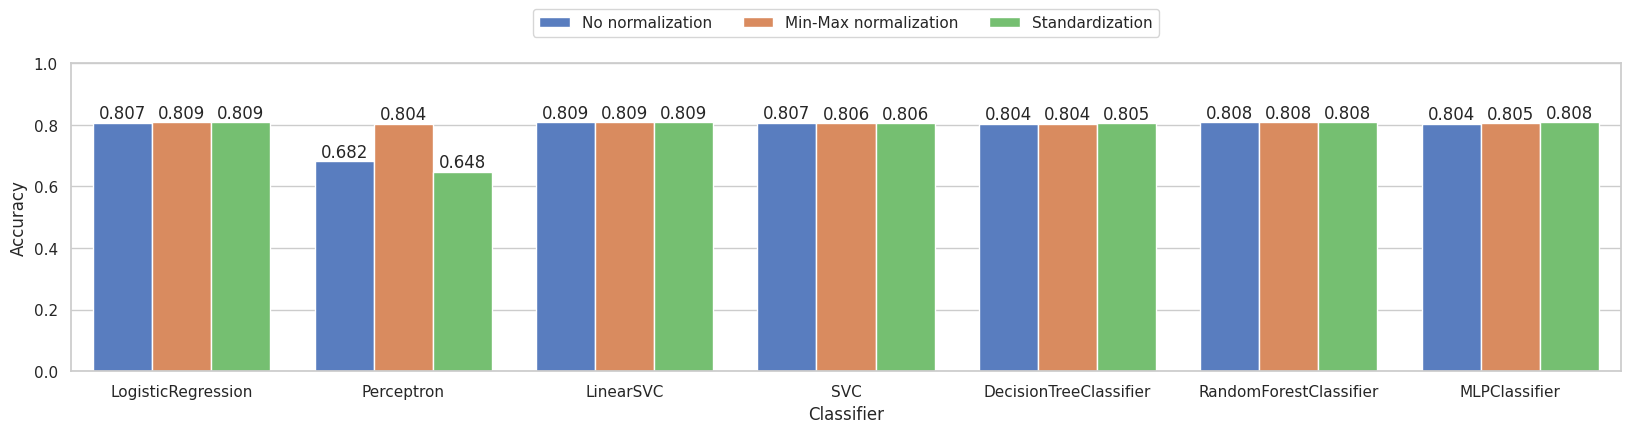

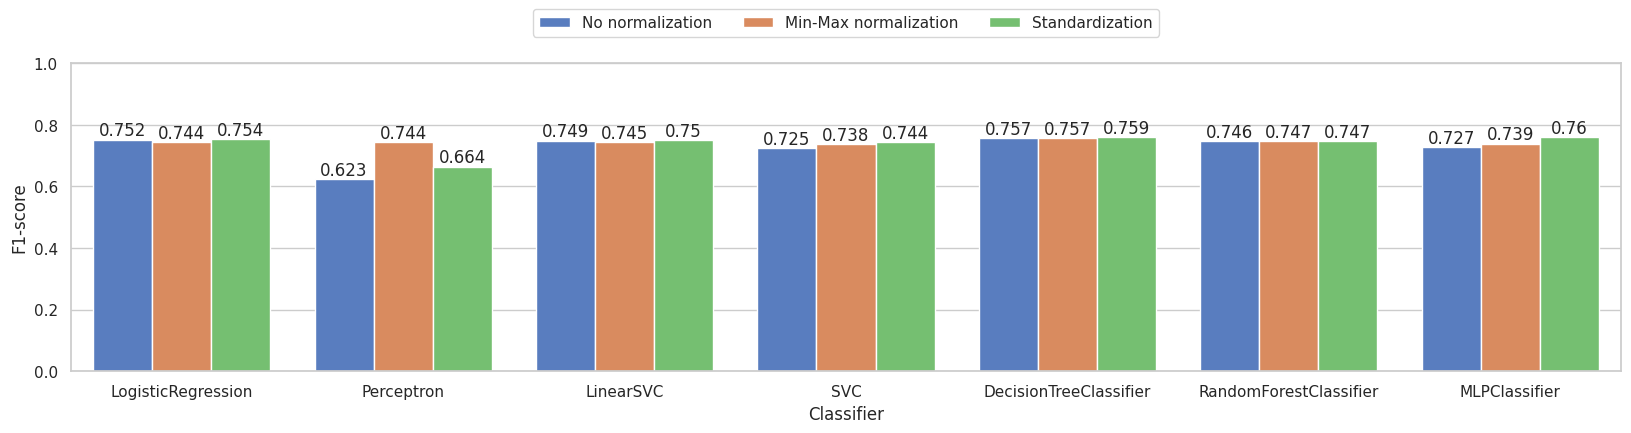

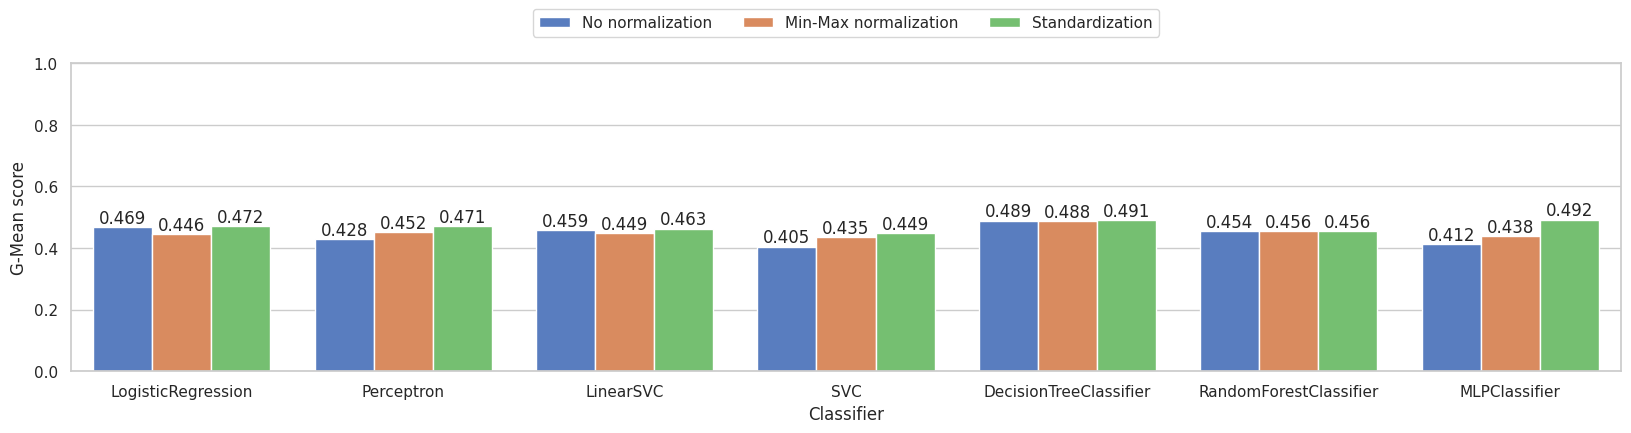

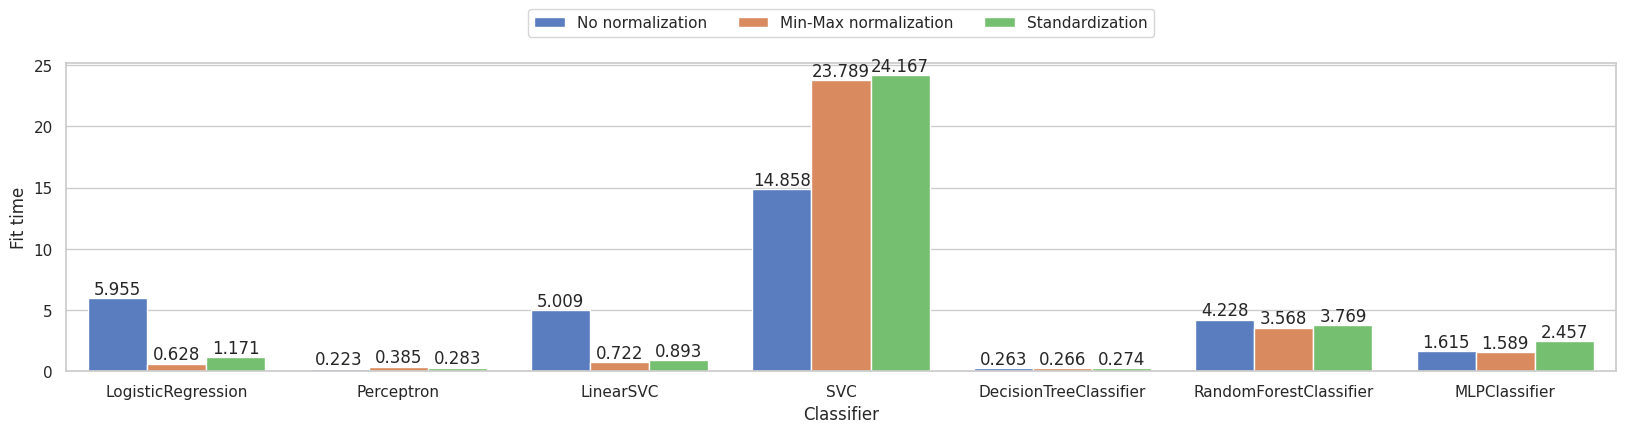

In [281]:
plot_metrics(jm1_results)

#### Performance Evaluation of Classifiers on JM1 Dataset

##### Accuracy
- **Most classifiers except Perceptron**  consistently show good accuracy across all normalization methods, indicating stable performance.
- **Perceptron** exhibits noticeable variability in accuracy, suggesting sensitivity to data preprocessing steps.

##### F1-Score
- **Most classifiers** do better with **Standardization**, but not a significant improvement though.
- The **Perceptron** improves in F1-score with **Min-Max normalization**, significant given its lower score without normalization.

##### G-Mean Score
- G-Mean scores are moderate across classifiers, suggesting **none of them can handle class imbalance**.
- Normalization methods do not significantly impact G-Mean scores, implying class balance management is not highly dependent on data scaling. **Standardization** though, seems to improve the results slighly.

##### Fit Time
- **SVC** generally has longer training times, especially with **normalization methods**, likely due to model complexity.
- **Perceptron and Decision Tree** have significantly lower training times than the rest of the algorithms.
- **Logistic Regression, Linear SVC and Random Forest** have longer fit times while trained without any **normalization method**.
- **MLP and Random Forest** show a balance in fit time, neither the quickest nor the slowest, suggesting moderate computational efficiency.

### mc1 dataset

In [282]:
mc1_results = pd.concat([df_mc1_nn_results, df_mc1_mmn_results, df_mc1_fs_results])
mc1_results = mc1_results.round(3)
mc1_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.993,0.991,0.343,17.140,No normalization
1,Perceptron,0.991,0.988,0.084,0.171,No normalization
2,LinearSVC,0.993,0.989,0.084,8.360,No normalization
3,SVC,0.993,0.989,0.084,1.471,No normalization
4,DecisionTreeClassifier,0.993,0.992,0.554,0.213,No normalization
5,RandomForestClassifier,0.994,0.993,0.498,4.096,No normalization
6,MLPClassifier,0.993,0.989,0.084,1.704,No normalization
0,LogisticRegression,0.993,0.989,0.125,0.911,Min-Max normalization
1,Perceptron,0.992,0.989,0.084,0.254,Min-Max normalization
2,LinearSVC,0.993,0.989,0.125,0.347,Min-Max normalization


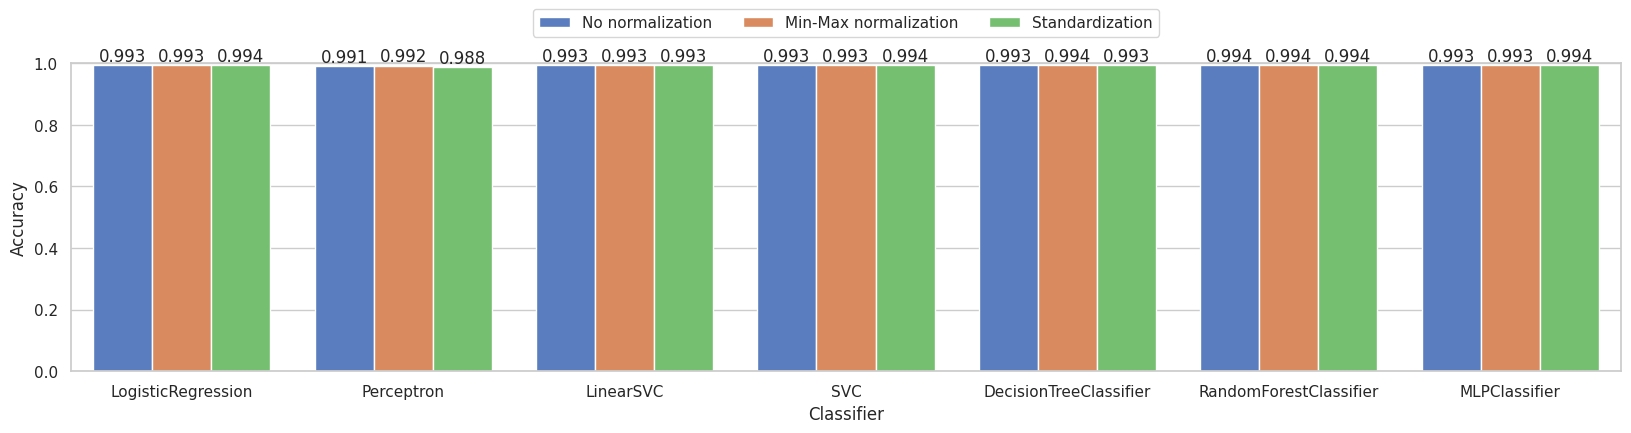

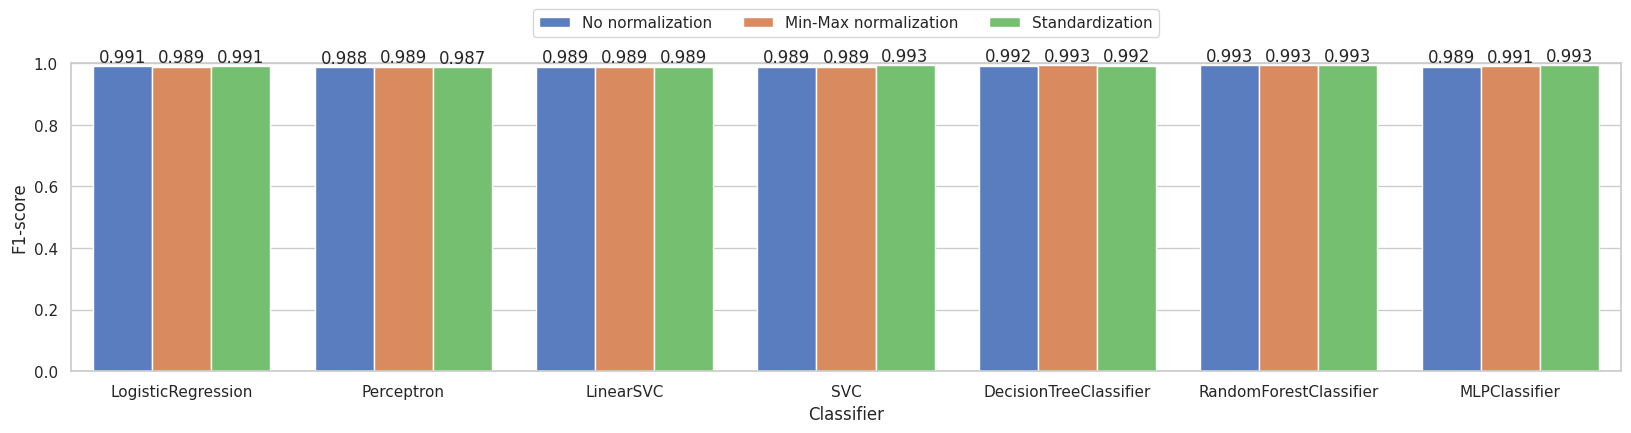

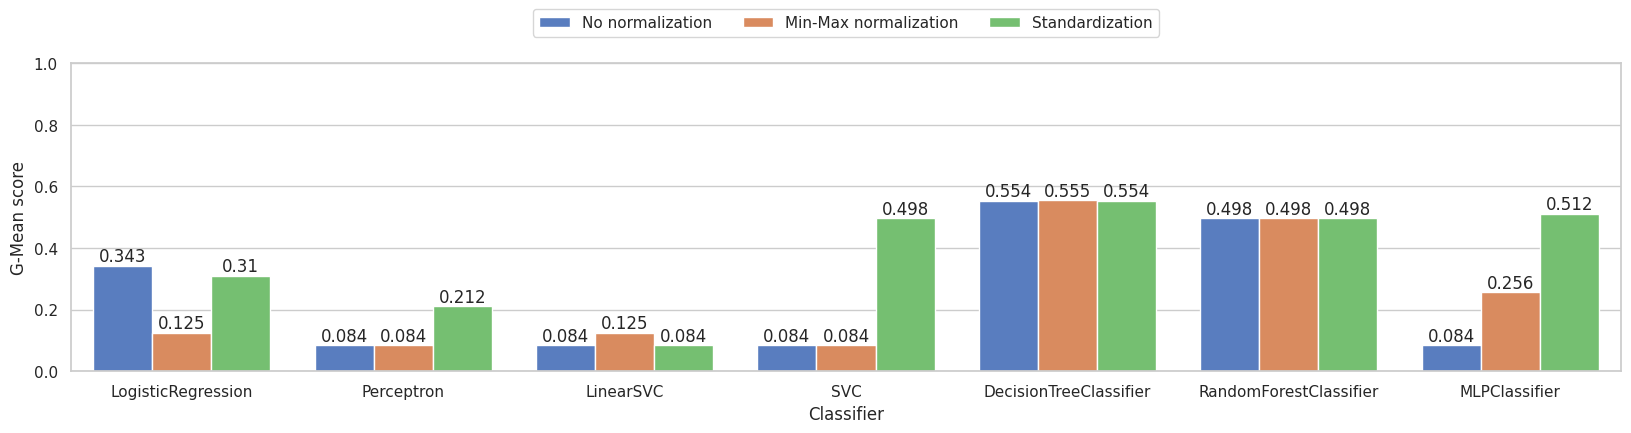

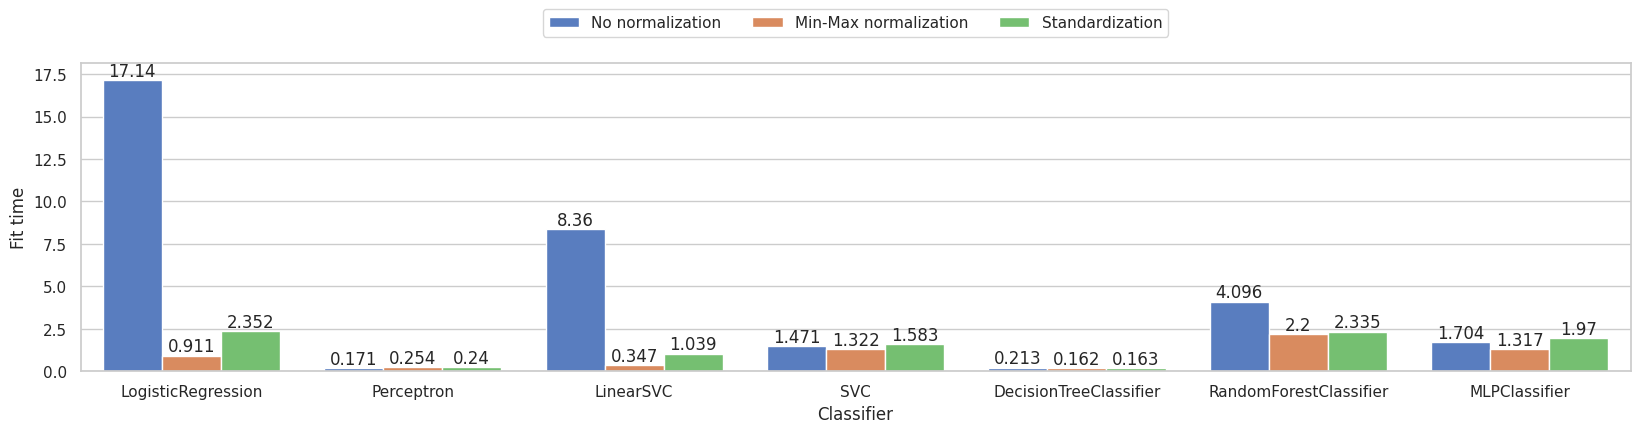

In [283]:
plot_metrics(mc1_results)

#### Performance Evaluation of Classifiers on MC1 Dataset

##### Accuracy
- **All classifiers** exhibit exceptionally **high accuracy despite the normalization method**, with most achieving above **0.993**. This suggests that the models are well-tuned to the dataset and the dataset probably lacks complexity (if we consider the performance on the other datasets).

##### F1-Score
- Similar to accuracy, F1-scores are also remarkably **high across all classifiers**, indicating a strong balance between precision and recall. Again, there are **no significant differences between normalization methods**.

##### G-Mean Score
- Despite high accuracy and F1-scores, G-Mean scores vary significantly among classifiers, with the **Decision Tree** showing the highest score, which implies better performance on the imbalanced classes.
- The low G-Mean scores for some classifiers like the **Perceptron** and **SVC** with **no normalization and Min-Max normalization** suggest that they **can not handle class imbalance** as effectively.

##### Fit Time
- The **Logistic Regression** has a notably longer fit time without normalization but is more efficient with **Min-Max normalization** and **Standardization**.
- **Linear SVC** experiences a significant reduction in fit time with **Min-Max normalization** and **Standardization**, indicating this preprocessing step can greatly influence the efficiency of this model.
- **Decision Tree** consistently shows quick fit times, making it an efficient choice for relatively big datasets.

### pc3 dataset

In [284]:
pc3_results = pd.concat([df_pc3_nn_results, df_pc3_mmn_results, df_pc3_fs_results])
pc3_results = pc3_results.round(3)
pc3_results

,Classifier,Accuracy,F1-score,G-Mean score,Fit time,Normalization method
0,LogisticRegression,0.900,0.877,0.485,0.932,No normalization
1,Perceptron,0.698,0.723,0.326,0.237,No normalization
2,LinearSVC,0.901,0.875,0.464,0.448,No normalization
3,SVC,0.898,0.849,0.303,0.174,No normalization
4,DecisionTreeClassifier,0.890,0.861,0.415,0.124,No normalization
5,RandomForestClassifier,0.895,0.848,0.302,2.543,No normalization
6,MLPClassifier,0.897,0.849,0.303,0.540,No normalization
0,LogisticRegression,0.897,0.856,0.346,0.083,Min-Max normalization
1,Perceptron,0.894,0.851,0.329,0.102,Min-Max normalization
2,LinearSVC,0.897,0.856,0.346,0.100,Min-Max normalization


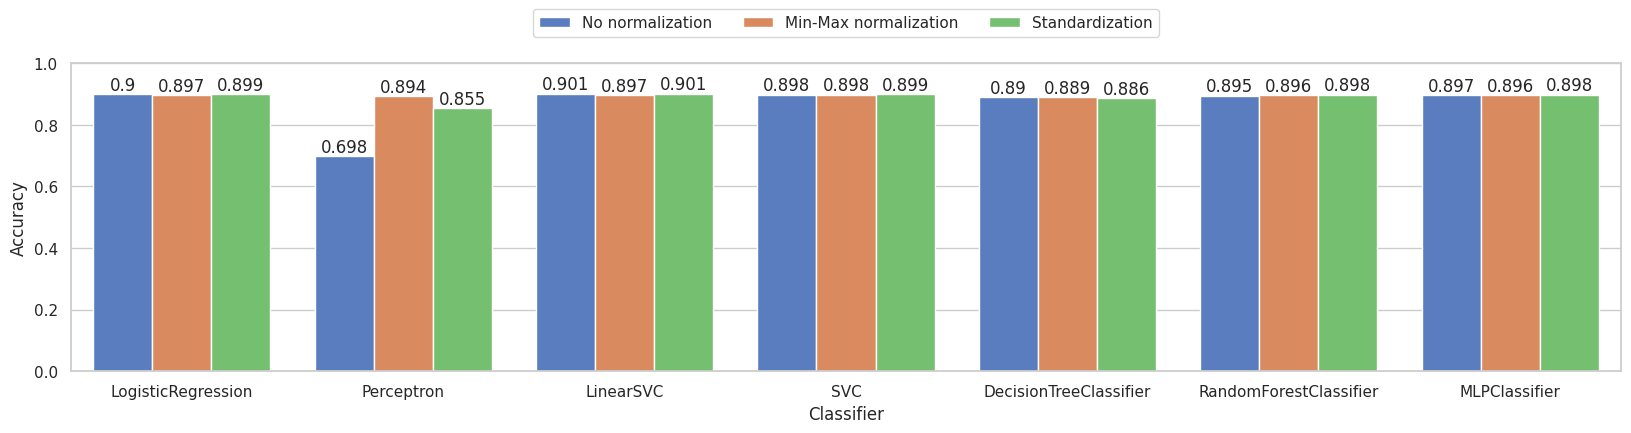

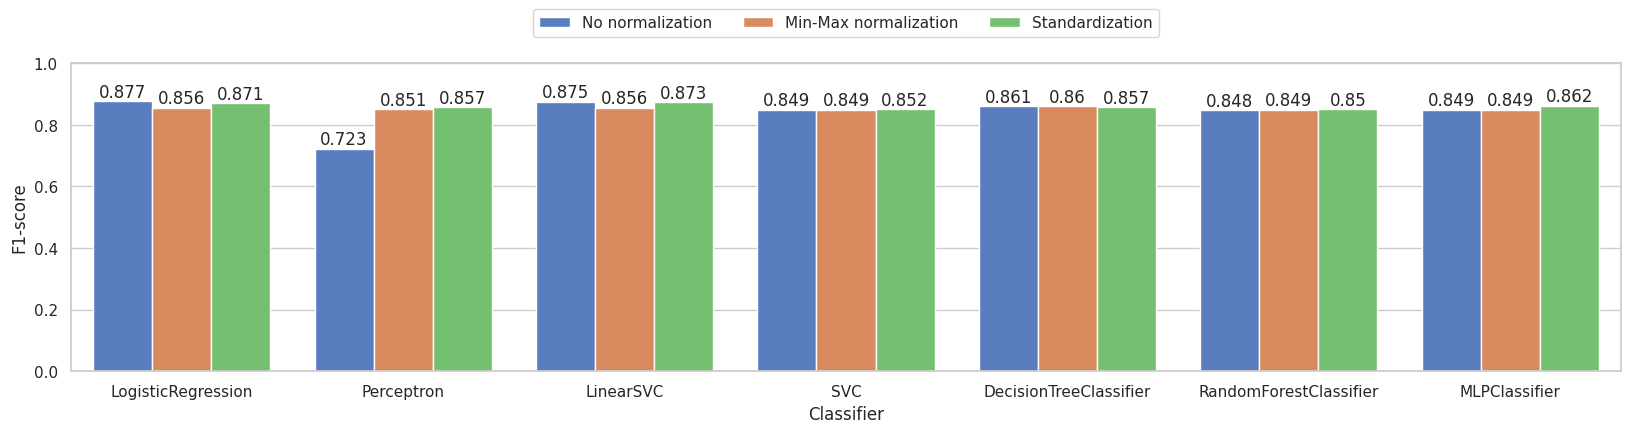

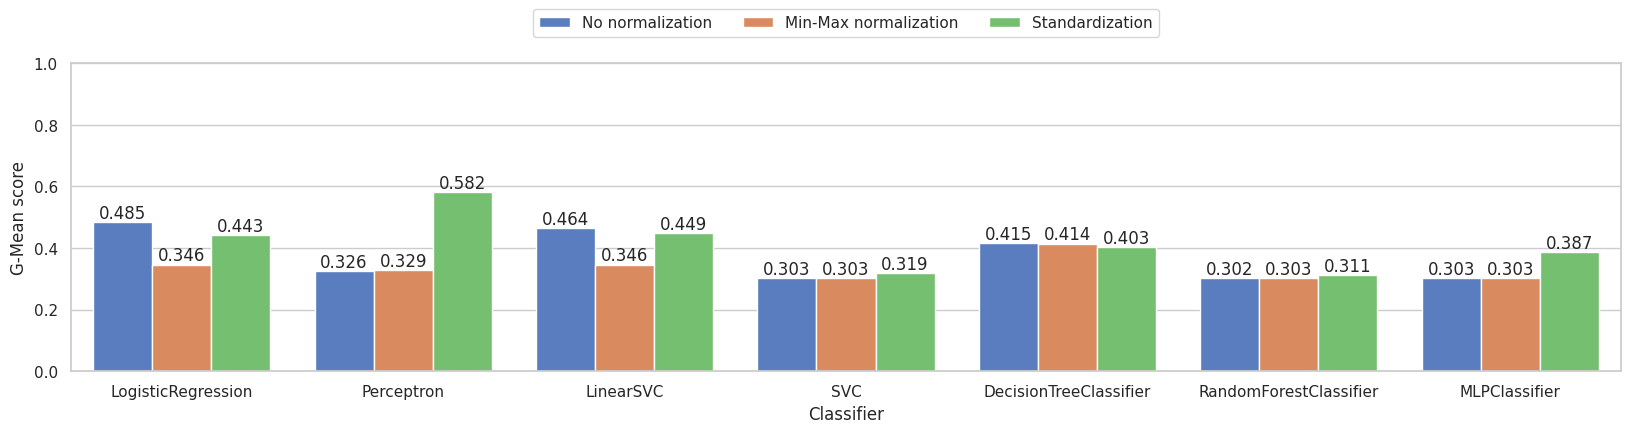

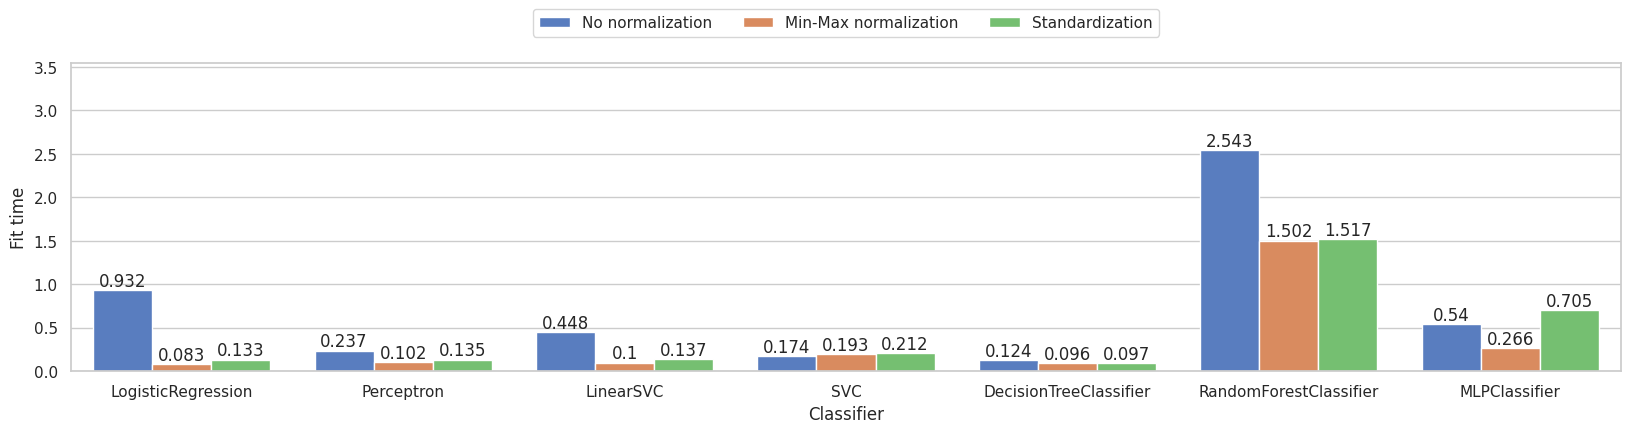

In [285]:
plot_metrics(pc3_results)

#### Performance Evaluation of Classifiers on PC3 Dataset

##### Accuracy:
- **Most classifiers except Perceptron** demonstrate high accuracy across all normalization methods. Their performance is consistent, with **Linear SVC** slightly outperforming in the non-normalized and standardized scenarios.
- The **Perceptron** shows the largest improvement in accuracy when moving from no normalization to **Min-Max normalization**, suggesting it benefits significantly from feature scaling.

##### F1-Score:
- The F1-scores are generally high for all classifiers, indicating a good balance of precision and recall. **Most classifiers** maintains a high F1-score across different normalization methods, while **Perceptron** sees a substantial increase with **Min-Max normalization** and **Standardization**.

##### G-Mean Score:
- **G-Mean scores** suggest some variability in the classifiers' ability to handle class balance. Overall, classifiers have **poor performance when considering class imbalance**.
- **Logistic Regression** and **Linear SVC** perform worse with **Min-Max normalization**, while **Perceptron** and **MLP** improve their performance with **Standardization**.
- **SVC, Decision Tree and Random Forest** have almost the same performance across the different **normalization methods**.

##### Fit Time:
- **Logistic Regression and Random Forest** have the most notable decrease in fit time with **both normalization methods**, suggesting that scaling can have a considerable effect on the computational efficiency of certain models.
- **MLP** once again increased its training time when trained after **Standardization**, while decreases it when trained after **Min-Max normalization**. 

<a id='5'></a>
## Performance Summary of Classifiers Across Datasets

##### Accuracy
- Classifiers like **Logistic Regression** and **Linear SVC** demonstrate high and stable accuracy across all datasets and normalization methods.
- **Perceptron** shows notable improvement in accuracy with **Min-Max normalization** across datasets, indicating its sensitivity to feature scaling.

##### F1-Score
- High F1-scores are consistently observed across all classifiers, suggesting a robust balance between precision and recall. The **Perceptron** benefits from **Min-Max normalization** and **Standardization**.

##### G-Mean Score
- To begin with, **all datasets are higly imbalanced**. While most classifiers do well in Accuracy and F1-Score, the **G-Mean score shows that all of them have medium to bad performance when taking into account the class imbalance**.
- The G-Mean scores vary among classifiers, with some, like the **Decision Tree**, performing a bit better on imbalanced classes. 
- **Min-Max normalization** does not significantly impact G-Mean scores for most classifiers, but **Standardization** slightly improves the G-Mean scores across datasets.

##### Fit Time
- Classifiers like **Perceptron** and **Decision Tree** are observed to have lower training times, indicating efficiency.
- **Random Forest** and **Logistic Regression** show decreased fit times with normalization methods, suggesting that scaling can optimize computational efficiency for these models.
- **MLP** shows a peculiar trend in training duration, with an increased fit time under **Standardization** possibly due to the unbounded nature of the data affecting the stability and rate of convergence. Conversely, fit time decreases with **Min-Max normalization**, likely because the bounded and uniform scale of input features facilitates a smoother and faster gradient descent process.